# Week 02 Data Preprocessing and Visualization 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_extraction.fetch_data import DailyStockDataLoader, FundamentalDataLoader
from data_engineering.feature_engineering import FeatureEngineering
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

ticker = 'NVDA'
load_dotenv()

/var/folders/hl/6492kk1939x_mv_8fr9qfz_40000gn/T/ipykernel_91052/314590625.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


True

In [2]:
row_data_path = '../../data/row/'
processed_data_path = '../../data/processed/'

## Check and handle empty data

In stock analysis tasks, using fitted values to fill in empty data is harmful to accurate prediction results, so empty data entries should be deleted.

In [33]:
# Example usage
ts_loader = DailyStockDataLoader()
NVDA_5_years_daily_data = ts_loader.load_daily_row_stock_data(
    ticker, last_n_years=5)
NVDA_5_years_daily_data.sort_index(inplace=True)
NVDA_5_years_daily_data.isnull().values.any()

No new data available for NVDA.


False

## Data merging and time alignment
The time accuracy of the 5-year historical data we obtained is uneven. You need to merge all historical data together so that all data have the same time accuracy.
> Difficulty: How to deal with Volumes of different time scales?

## Auxiliary data broadcast
In addition to historical stock prices, other data such as cash flow and assets and liabilities need to be integrated into your features. But the data we obtain are quarterly or even annual. Because these data are disclosed in financial reports released every quarter, and are manually entered as data by some third-party projects (such as yfinance)

As data for auxiliary forecasting, even if there are only 8 financial reports in a two-year time scale, the financial report data still need to be broadcast to each quarter's time period. The data for the past 3-5 years may need to be obtained by querying the company's financial reports, and Prepare to simplify data dimensions and explore their correlations through subsequent feature engineering.

Use the forward fill method to generate monthly data from quarterly data and select some key financial indicators for visualization. Calculate volatility and draw line charts to observe.

In [4]:
def generate_and_save_monthly_report_data(report_name):
    # Load the balance sheet data
    report_data = pd.read_csv(
        row_data_path + 'NVDA_' + report_name + '_quarterly_5_years.csv',
        index_col='fiscalDateEnding', 
        parse_dates=True)
    monthly_data = pd.DataFrame(columns=report_data.columns)

    for i in range(report_data.shape[0]):
        current_row = report_data.iloc[i]
        current_date = report_data.index[i]
        
        for days in [30, 60, 91]:
            new_date = current_date + pd.DateOffset(days=days)
            # Perform integer division by 3 for numeric columns
            new_row = current_row.copy()
            for col in new_row.index:
                if pd.api.types.is_numeric_dtype(new_row[col]):
                    new_row[col] = new_row[col] // 3
            monthly_data.loc[new_date] = new_row
    # Replace all empty cells with 0
    monthly_data.fillna(0, inplace=True)
    monthly_data.index.name = 'fiscalDateEnding'
    monthly_data.sort_index(inplace=True)
    # Save processed data
    monthly_data.to_csv(processed_data_path + 'NVDA_' + report_name + '_monthly_5_years.csv')

Run the code

In [5]:
financial_reports = ['income_statement', 'balance_sheet', 'cash_flow']
for report in financial_reports:
    generate_and_save_monthly_report_data(report_name=report)

/var/folders/hl/6492kk1939x_mv_8fr9qfz_40000gn/T/ipykernel_83897/3459945712.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_data.loc[new_date] = new_row
/var/folders/hl/6492kk1939x_mv_8fr9qfz_40000gn/T/ipykernel_83897/3459945712.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monthly_data.fillna(0, inplace=True)
/var/folders/hl/6492kk1939x_mv_8fr9qfz_40000gn/T/ipykernel_83897/3459945712.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future vers

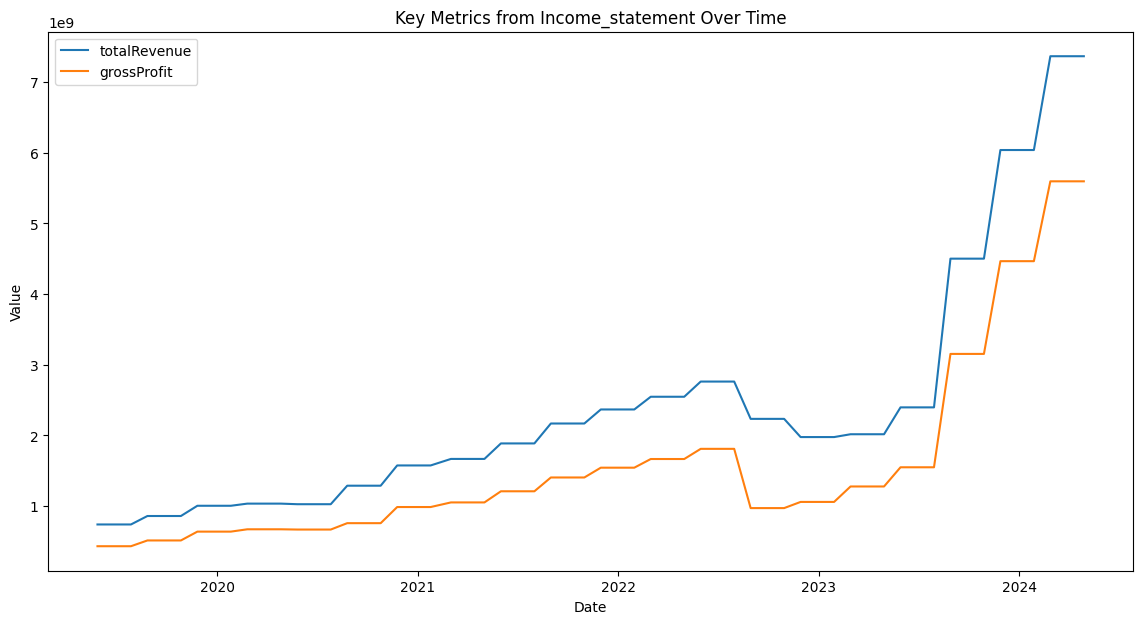

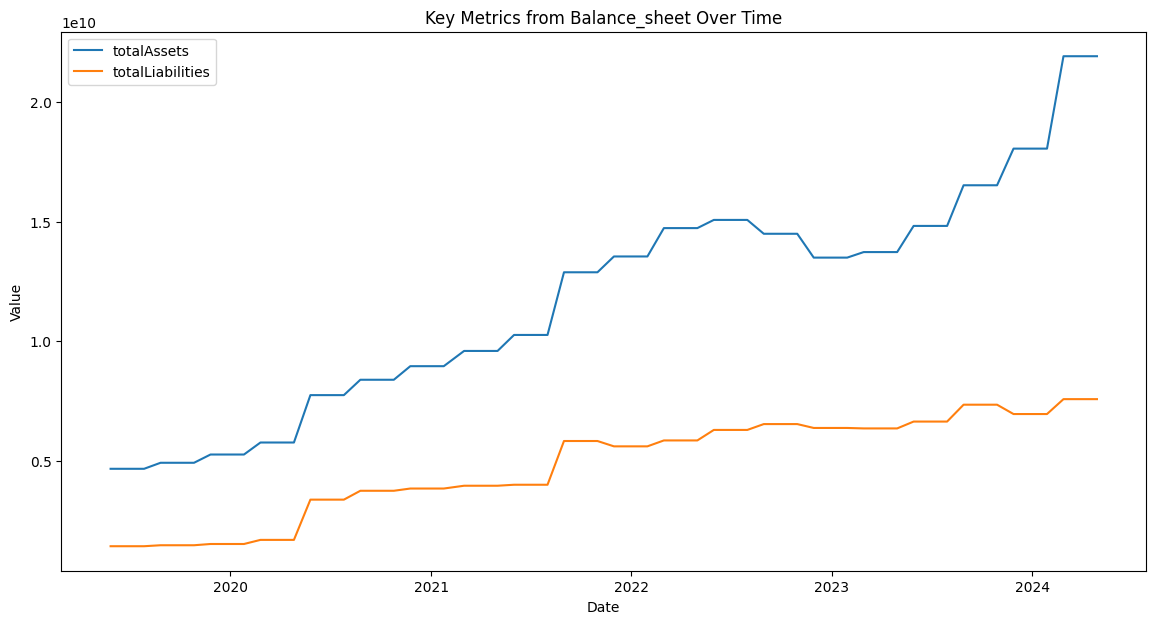

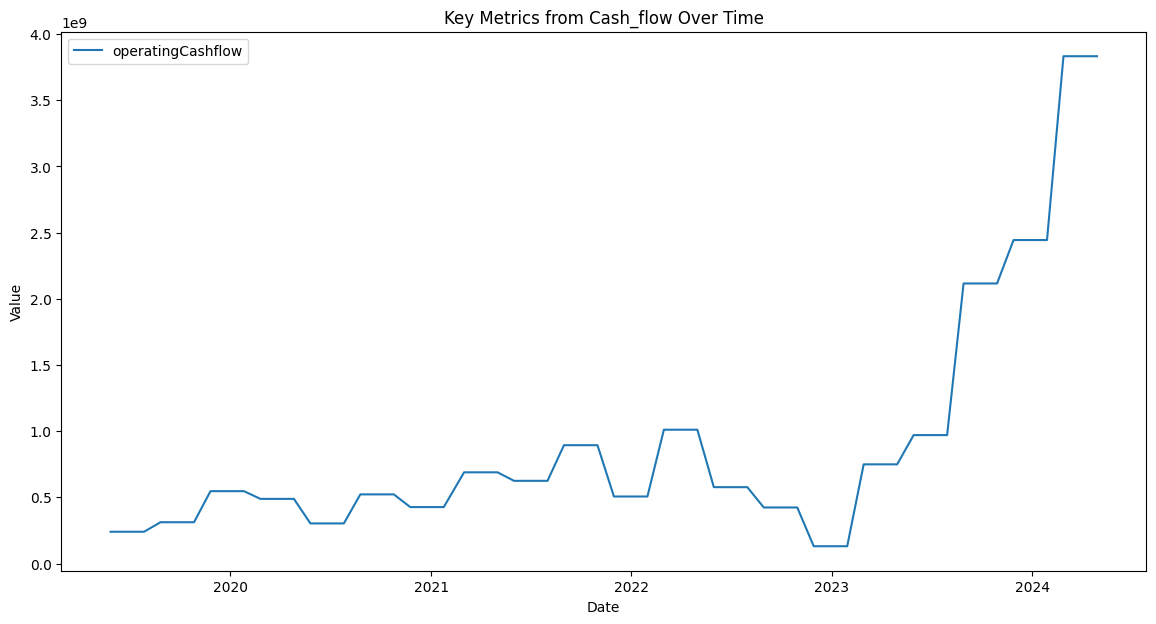

In [6]:
def plot_key_financial_metrics(report_name, key_metrics):
    # Load the processed monthly data
    file_path = processed_data_path + 'NVDA_' + report_name + '_monthly_5_years.csv'
    data = pd.read_csv(
        file_path, index_col='fiscalDateEnding', parse_dates=True)

    # Plot each key metric
    plt.figure(figsize=(14, 7))
    for metric in key_metrics:
        if metric in data.columns:
            plt.plot(data.index, data[metric], label=metric)

    plt.title(f'Key Metrics from {report_name.capitalize()} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Define key metrics for each financial report
key_metrics = {
    'income_statement': ['totalRevenue', 'grossProfit'],
    'balance_sheet': ['totalAssets', 'totalLiabilities'],
    'cash_flow': ['operatingCashflow', 'investingCashflow']
}

# Plot key metrics for each financial report
for report, metrics in key_metrics.items():
    plot_key_financial_metrics(report, metrics)

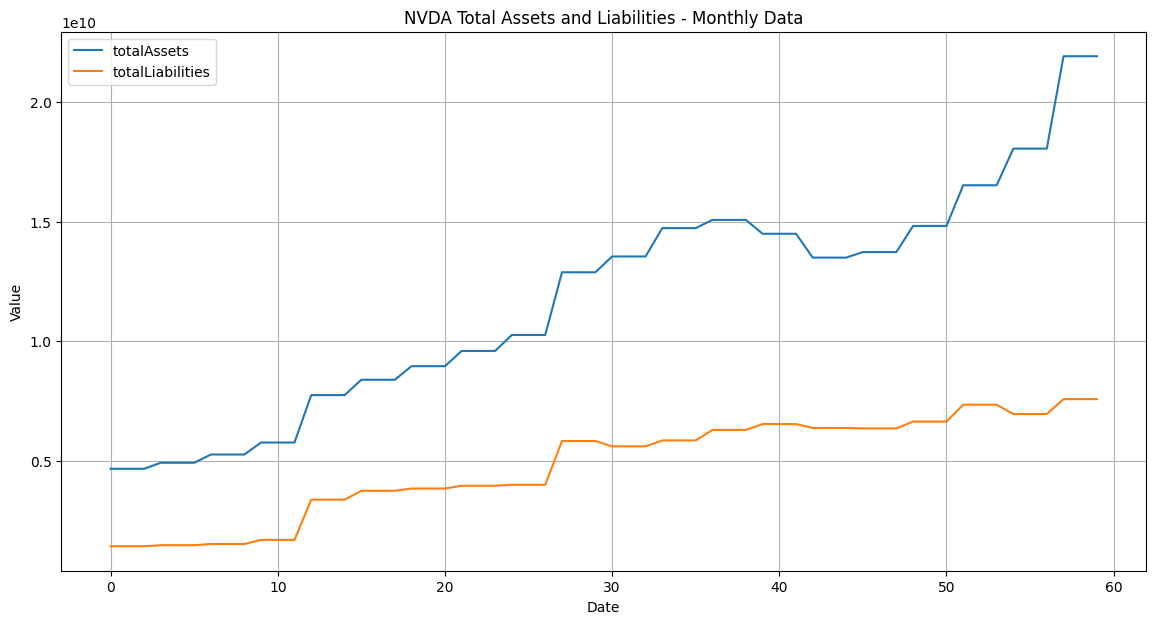

In [7]:
balance_sheet_monthly = pd.read_csv(
    processed_data_path + "NVDA_balance_sheet_monthly_5_years.csv")
# Visualize key indicators
balance_sheet_monthly[['totalAssets', 'totalLiabilities']].plot(
    figsize=(14, 7))
plt.title('NVDA Total Assets and Liabilities - Monthly Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Historical volatility
According to the logarithmic price change method formula:
$$
\begin{gathered}
X_i=\ln \frac{P_{i+1}}{P_i}=\ln P_{i+1}-\ln P_i \\
\bar{X}=\frac{1}{N} \sum X_i \\
\sigma=\sqrt{\frac{\sum\left(X_i-\bar{X}\right)^2}{N-1}}
\end{gathered}
$$

Calculate all historical volatility with 1d accuracy and 2 years, and draw it as a plot together with the box chart of historical price data. 

Find whether NVDA (i.e. NVIDIA) has corresponding news/event support when volatility occurs abnormally.


Save processed data

In [ ]:
loader = FeatureEngineering()
data = loader.load_commen_features(ticker, last_n_years=3)

In [17]:
# Identify dates with abnormal changes in volatility (> 3%)
abnormal_volatility_changes = data[abs(data['volatility_change']) > 0.01]

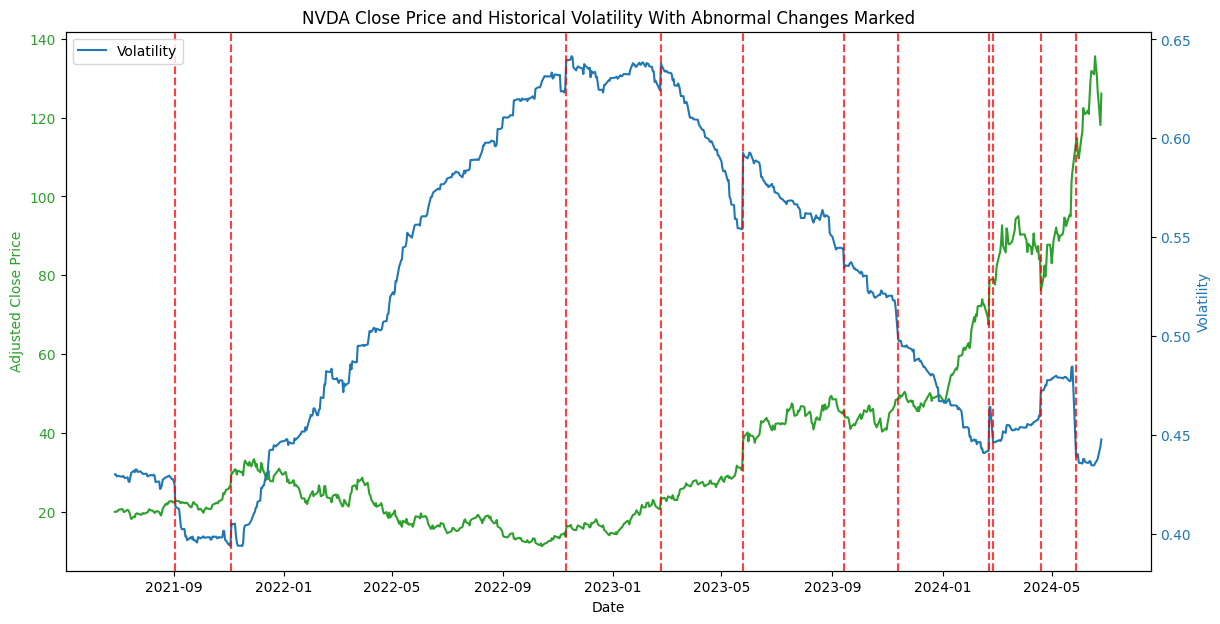

In [18]:
# Plotting with abnormalities marked
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close prices
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close Price', color=color)
ax1.plot(data.index, data['adjusted_close'],
         color=color, label='Adjusted Close Price')
ax1.tick_params(axis='y', labelcolor=color)

# Plot volatility
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Volatility', color=color)
ax2.plot(data.index, data['volatility'], color=color, label='Volatility')
ax2.tick_params(axis='y', labelcolor=color)

# Mark abnormalities
for date in abnormal_volatility_changes.index:
    ax2.axvline(x=date, color='r', linestyle='--', alpha=0.75)

plt.title('NVDA Close Price and Historical Volatility With Abnormal Changes Marked')
plt.legend()
plt.show()

In [19]:
# Print dates and changes of abnormal volatility changes
print("Dates and Changes of Abnormal Volatility Changes:")
print(abnormal_volatility_changes.index)

Dates and Changes of Abnormal Volatility Changes:
DatetimeIndex(['2024-05-28', '2024-04-19', '2024-02-26', '2024-02-22',
               '2023-11-13', '2023-09-14', '2023-05-25', '2023-02-23',
               '2022-11-10', '2021-11-04', '2021-09-03'],
              dtype='datetime64[ns]', name='date', freq=None)


- 2022-03-24:
  - [Nvidia Would Consider Using Intel as a Foundry, CEO Says](https://www.bloomberg.com/news/articles/2022-03-23/nvidia-ceo-to-look-at-intel-for-foundry-says-shift-will-be-hard)
- 2022-11-10:
  - [Nvidia will reportedly sell new chips to China that still meet U.S. rules](https://www.cnbc.com/2023/11/10/nvidia-will-reportedly-sell-new-chips-to-china-that-still-meet-us-rules.html)
- 2023-02-23
  - [Nvidia shares up 14% on earnings and bullish outlook on A.I.](https://www.cnbc.com/2023/02/23/nvidia-stock-up-12percent-on-earnings-ai-potential.html)
- 2023-05-25
  - [Nvidia shares surge to record close with 24% rally](https://www.cnbc.com/2023/05/25/nvidia-on-track-for-record-high-driven-by-ai-chip-demand.html)
- 2023-09-14
  - [Nvidia and Capital One back Databricks at $43 billion valuation in latest funding round](https://www.cnbc.com/2023/09/14/nvidia-and-capital-one-invest-in-databricks-at-43-billion-valuation.html)
- 2023-11-13
  - [Nvidia unveils H200, its newest high-end chip for training AI models](https://www.cnbc.com/2023/11/13/nvidia-unveils-h200-its-newest-high-end-chip-for-training-ai-models.html)

Faced with data that is unevenly distributed over time (the longer the data, the smaller the amount of data), how should we deal with it when performing feature engineering and window sampling?
What is the relationship between data proportion?